In [58]:
!py -m pip install -q "monai-weekly[nibabel, tqdm, einops]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

In [59]:
import os
import shutil
import tempfile

import matplotlib.pyplot as plt
from tqdm import tqdm

from monai.losses import DiceCELoss
from monai.inferers import sliding_window_inference
from monai.transforms import (
    AsDiscrete,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandFlipd,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    ScaleIntensityRanged,
    Spacingd,
    RandRotate90d,
    ResizeWithPadOrCropd,
    SpatialCrop
)

from monai.config import print_config
from monai.metrics import DiceMetric
from monai.networks.nets import UNETR,SwinUNETR,UNet

from monai.data import (
    CacheDataset,
    DataLoader,
    Dataset,
    load_decathlon_datalist,
    decollate_batch,
)

from monai.networks.layers import Norm
import torch

print_config()

MONAI version: 1.3.dev2328
Numpy version: 1.24.3
Pytorch version: 2.0.1+cpu
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 6a85cf941ef286e967b627b6b4001df7b247f301
MONAI __file__: c:\Users\nayak\AppData\Local\Programs\Python\Python311\Lib\site-packages\monai\__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.1.0
scikit-image version: NOT INSTALLED or UNKNOWN VERSION.
Pillow version: 9.5.0
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.15.2+cpu
tqdm version: 4.65.0
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.5
pandas version: 2.0.2
einops version: 0.6.1
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing t

In [60]:
#image list
img_files=[os.path.join(path[0],file) for path in os.walk(r'c://Users//nayak//Downloads//archive (1)//')  for file in path[-1]  if 'pt' in path[0] if 'vol' in file]  
len(img_files)

131

In [61]:
#segmentaim list
seg_path=r'c:\\Users\\nayak\\Downloads\\archive (1)\\segmentations'


seg_files=[seg_path+'\\segmentation-'+file.split('-')[-1] for file in img_files]  
print(img_files[2],seg_files[2])

c://Users//nayak//Downloads//archive (1)//volume_pt1\volume-10.nii c:\\Users\\nayak\\Downloads\\archive (1)\\segmentations\segmentation-10.nii


In [62]:
#monai dataset need dictonary
data_dicts = [{"image": image_name, "label": label_name} for image_name, label_name in zip(img_files, seg_files)]
train_files, val_files = data_dicts[65:130], data_dicts[-1:]

In [63]:
class ToLiver(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, label = sample['image'], sample['label']
        label[label==2]=1
        return {'image': image,
                'label': label}

In [64]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-175,
            a_max=250,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(128, 128, 32),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),

        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[0],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[1],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[2],
            prob=0.10,
        ),
        RandRotate90d(
            keys=["image", "label"],
            prob=0.10,
            max_k=3,
        ),
      ToLiver()
    ]
)

c:\Users\nayak\AppData\Local\Programs\Python\Python311\Lib\site-packages\monai\utils\deprecate_utils.py:321: FutureWarning: monai.transforms.io.dictionary LoadImaged.__init__:image_only: Current default value of argument `image_only=False` has been deprecated since version 1.1. It will be changed to `image_only=True` in version 1.3.
  warn_deprecated(argname, msg, warning_category)


In [65]:
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        ScaleIntensityRanged(keys=["image"], a_min=-175, a_max=250, b_min=0.0, b_max=1.0, clip=True),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        ToLiver()
    ]
)

In [66]:
#create data set with the transform for the train and val


train_ds =CacheDataset(
    data=train_files,
    transform=train_transforms,
)
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True)

Loading dataset:  38%|███▊      | 25/65 [03:37<05:47,  8.70s/it]
Exception ignored in: <function tqdm.__del__ at 0x0000017A2A402F20>
Traceback (most recent call last):
  File "c:\Users\nayak\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\std.py", line 1145, in __del__
    self.close()
  File "c:\Users\nayak\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\std.py", line 1264, in close
    if self.disable:
       ^^^^^^^^^^^^
AttributeError: 'tqdm' object has no attribute 'disable'


RuntimeError: applying transform <monai.transforms.io.dictionary.LoadImaged object at 0x0000017A44500810>

In [ ]:
val_ds =CacheDataset(
    data=val_files,
    transform=val_transforms,
)

Loading dataset: 100%|██████████| 1/1 [00:08<00:00,  8.70s/it]


image shape: torch.Size([1, 234, 181, 219]), label shape: torch.Size([1, 234, 181, 219])


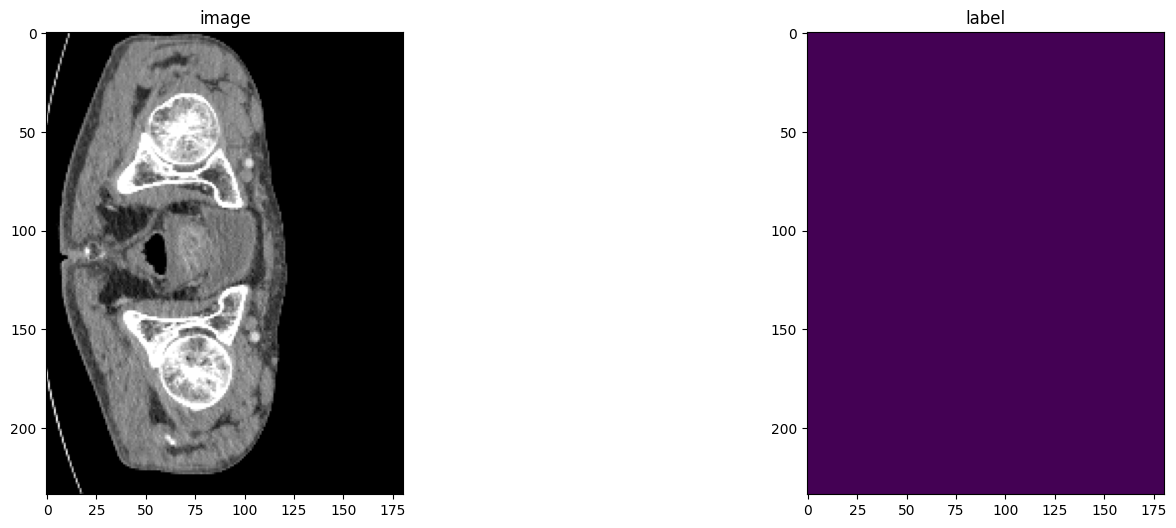

In [ ]:
img = val_ds[0]["image"]
label = val_ds[0]["label"]
img_shape = img.shape
label_shape = label.shape
print(f"image shape: {img_shape}, label shape: {label_shape}")
plt.figure("image", (18, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(img[ 0,:, :,40].detach().cpu(), cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[0, :, :, 40].detach().cpu())
plt.show()